1) Computes all plots used in article

2) Runs significance tests on multitask vs baseline comparisons per dataset

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
sns.set_style('whitegrid')
sns.set_context("paper")
%matplotlib inline

In [5]:
plt.rcParams[u'font.family'] = [u'monospace']
plt.rcParams[u'font.monospace'] = [u'Computer Modern Typewriter']

In [6]:
# multitask vs single task
multitask_dir = '../experiment_output/multitask_base_experiment/evaluation/'
multif0_dir = '../experiment_output/multitask_singletask_mf0/evaluation/'
melody_dir = '../experiment_output/multitask_singletask_mel/evaluation/'
bass_dir = '../experiment_output/multitask_singletask_bass/evaluation/'
vocal_dir = '../experiment_output/multitask_singletask_vocal/evaluation/'

# synth data vs no synth data
multitask_nosynth_dir = '../experiment_output/multitask_nosynth/evaluation/'
multitask_nosynthguitar_dir = '../experiment_output/multitask_nosynthguitar/evaluation/'

# adjust number of tasks
mf0 = '../experiment_output/multitask_singletask_mf0/evaluation/'
mf0_mel = '../experiment_output/multitask_mf0_melody/evaluation/'
mf0_bass = '../experiment_output/multitask_mf0_bass/evaluation/'
mf0_voc = '../experiment_output/multitask_mf0_vocal/evaluation/'
mf0_mel_bass = '../experiment_output/multitask_mf0_mel_bass/'
mf0_mel_voc = '../experiment_output/multitask_mf0_mel_vocal/'
mf0_bass_voc = '../experiment_output/multitask_mf0_voc_bass/'
mf0_mel_bass_voc = '../experiment_output/multitask_base_experiment/'

# piano/guitar
mf0_piano = '../experiment_output/multitask_all_plus_piano/evaluation/'
mf0_guitar = '../experiment_output/multitask_all_plus_guitar/evaluation/'
mf0_piano_guitar = '../experiment_output/multitask_all_plus_piano_guitar/evaluation'

# number of harmonics
harms_5_dir = '../experiment_output/multitask_base_experiment/evaluation/'
harms_4_dir = '../experiment_output/multitask_4harms/evaluation/'
harms_3_dir = '../experiment_output/multitask_3harms/evaluation/'
harms_2_dir = '../experiment_output/multitask_2harms/evaluation/'
harms_1_dir = '../experiment_output/multitask_1harms/evaluation/'

In [129]:
def get_datapoints(dataset_name, folder, metric):
    csv_path = os.path.join(folder, '{}_scores.csv'.format(dataset_name))
    df = pd.DataFrame.from_csv(csv_path)
    datapoints = df[metric].tolist()
    return datapoints
    

def get_task_datapoints(folder_list, task, metric='Accuracy'):
    if task == 'multif0':
        datasets = ['bach10', 'su', 'mdb_mf0', 'maps']
        dataset_names = ['Bach10', 'Su', 'MDB$_{mf0}$', 'MAPS']
    elif task == 'melody':
        datasets = ['wj_mel', 'mdb_mel', 'orchset']
        dataset_names = ['WJ$_{mel}$', 'MDB$_{mel}$', 'Orchset']
    elif task == 'bass':
        datasets = ['wj_bass']
        dataset_names = ['WJ$_{bass}$']
    elif task == 'vocal':
        datasets = ['ikala']
        dataset_names = ['Ikala']

    datapoints_list = []
    keys = []
    for dataset in datasets:
        for folder in folder_list:
            datapoints = get_datapoints(dataset, folder, metric)
            datapoints_list.append(datapoints)
            keys.append('{}-{}-{}'.format(dataset, folder, metric))
    
    return datapoints_list, dataset_names


def get_grouped_datapoints(folder_list, task, metric='Accuracy'):
    if task == 'multif0':
        datasets = ['bach10', 'su', 'mdb_mf0']#, 'maps']
    elif task == 'melody':
        datasets = ['wj_mel', 'mdb_mel', 'orchset']
    elif task == 'bass':
        datasets = ['wj_bass']
    elif task == 'vocal':
        datasets = ['ikala']

    datapoints_list = []
    keys = []
    for folder in folder_list:
        experiment_datapoints = []
        for dataset in datasets:
            datapoints = get_datapoints(dataset, folder, metric)
            experiment_datapoints.extend(datapoints)
        datapoints_list.append(experiment_datapoints)
    
    return datapoints_list

        
def add_plot(subplot_tuple, y_group_names, color_group_names, group_data, title,
             show_yaxis=True, legend_loc=None, xlim=None, color_palette=None,
             xlabel='Score', bbox_to_anchor=None, ncol=1):
    
    plt.subplot(subplot_tuple)
    plt.title(title, weight='bold')
    
    # get y-axis positions for each data point
    n_ygroups = len(y_group_names)
    n_colors = len(color_group_names)
    print("{} y-groups".format(n_ygroups))
    print("{} colors".format(n_colors))

    positions = []
    dotted_line_positions = []
    k = 0
    for i in range(n_ygroups):
        for j in range(n_colors):
            positions.append(k)
            k = k + 1
        dotted_line_positions.append(k)
        k = k + 1
        
    y_pos = []
    for i in np.arange(0, len(positions), n_colors):
        y_pos.append(np.mean(positions[i:i + n_colors]))

    current_palette = sns.color_palette(color_palette, n_colors)

    colors = current_palette*n_ygroups

    box = plt.boxplot(
        group_data, widths=0.8, positions=positions,
        patch_artist=True, showmeans=True,
        medianprops={'color': 'k'},
        meanprops=dict(marker='D', markeredgecolor='black',
            markerfacecolor='k'),
        vert=False
    )
    for patch, color in zip(box['boxes'], colors):
        patch.set_facecolor(color)

    plt.xlabel(xlabel)
    if show_yaxis:
        plt.yticks(y_pos, y_group_names, rotation='horizontal', weight='bold')
    else:
        plt.yticks(y_pos, ['']*n_ygroups, rotation='horizontal')

    for i in dotted_line_positions:
        if i < positions[-1]:
            plt.plot([0, 1], [i, i], '-', color='k')
        
    if xlim is not None:
        plt.xlim(xlim)

    plt.grid(axis='y')
        
    if legend_loc is not None:
        h_list = []
        for i, name in enumerate(color_group_names):
            h, = plt.plot([1, 1], 's', color=colors[i], markersize=10)
            h_list.append(h)

        h_list_rev = list(reversed(h_list))
        color_group_names_rev = list(reversed(color_group_names))
        lgd = plt.legend(
            tuple(h_list_rev), tuple(color_group_names_rev), ncol=ncol,
            loc=legend_loc, bbox_to_anchor=bbox_to_anchor,
            frameon=True, framealpha=1
        )
        
        for h in h_list:
            h.set_visible(False)


# Multi-task vs. Single-task

4 y-groups
2 colors
3 y-groups
2 colors
1 y-groups
2 colors
1 y-groups
2 colors


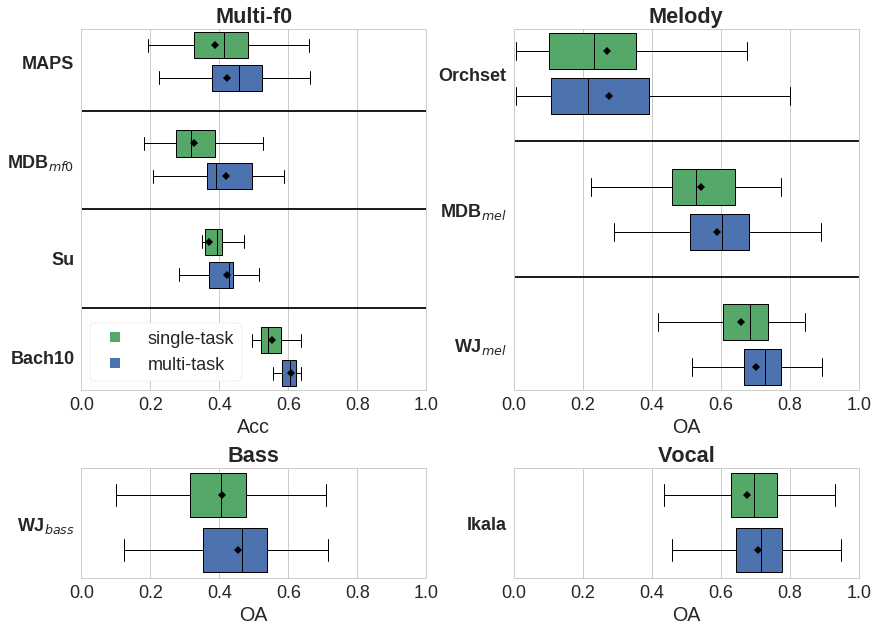

In [14]:
multif0_datapoints, datasets_mf0 = get_task_datapoints([multitask_dir, multif0_dir],'multif0', metric='Accuracy')
melody_datapoints, datasets_mel = get_task_datapoints([multitask_dir, melody_dir], 'melody', metric='Overall Accuracy')
bass_datapoints, datasets_bass = get_task_datapoints([multitask_dir, bass_dir], 'bass', metric='Overall Accuracy')
vocal_datapoints, datasets_vocal = get_task_datapoints([multitask_dir, vocal_dir], 'vocal', metric='Overall Accuracy')

plt.figure(figsize=(12, 12))
# plt.figure()
sns.set(font_scale=1.8)
sns.set_style('whitegrid')
add_plot(221, datasets_mf0, ['multi-task', 'single-task'], multif0_datapoints, 'Multi-f0',
             show_yaxis=True, legend_loc=3, xlim=[0, 1.0], xlabel='Acc')

add_plot(222, datasets_mel, ['multi-task', 'single-task'], melody_datapoints, 'Melody',
             show_yaxis=True, legend_loc=None, xlim=[0, 1.0], xlabel='OA')

add_plot(627, datasets_bass, ['multi-task', 'single-task'], bass_datapoints, 'Bass',
             show_yaxis=True, legend_loc=None, xlim=[0, 1.0], xlabel='OA')

add_plot(628, datasets_vocal, ['multi-task', 'single-task'], vocal_datapoints, 'Vocal',
             show_yaxis=True, legend_loc=None, xlim=[0, 1.0], xlabel='OA')

plt.tight_layout(pad=0.0, w_pad=0.0, h_pad=-1.5)

plt.savefig("../journal-paper-figs/multi-vs-singletask.pdf", format='pdf', bbox_inches='tight')

# Does augmented data help?

4 y-groups
2 colors
3 y-groups
2 colors
1 y-groups
2 colors
1 y-groups
2 colors


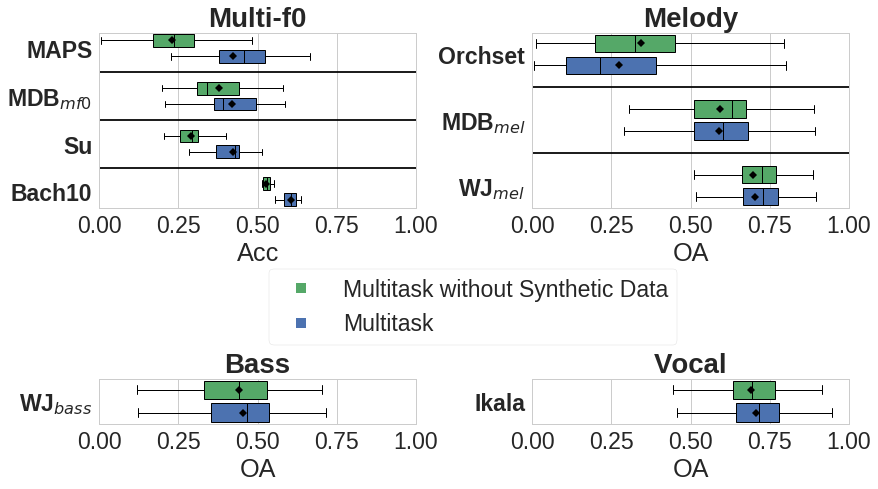

In [145]:
#folder_list = [multitask_dir, multitask_nosynthguitar_dir, multitask_nosynth_dir]
folder_list = [multitask_dir, multitask_nosynth_dir]
multif0_datapoints, datasets_mf0 = get_task_datapoints(folder_list,'multif0', metric='Accuracy')
melody_datapoints, datasets_mel = get_task_datapoints(folder_list, 'melody', metric='Overall Accuracy')
bass_datapoints, datasets_bass = get_task_datapoints(folder_list, 'bass', metric='Overall Accuracy')
vocal_datapoints, datasets_vocal = get_task_datapoints(folder_list, 'vocal', metric='Overall Accuracy')

plt.figure(figsize=(12, 9))
sns.set(font_scale=2.3)
sns.set_style('whitegrid')
#groups = ['ORIG + RMX + RMX-P + RMX-PG', 'ORIG + RMX + RMX-P', 'ORIG + RMX']
groups = ['Multitask', 'Multitask without Synthetic Data']
add_plot(221, datasets_mf0, groups, multif0_datapoints, 'Multi-f0',
             show_yaxis=True, legend_loc=3, xlim=[0, 1.0], xlabel='Acc',
        bbox_to_anchor=(0.5, -0.85))

add_plot(222, datasets_mel, groups, melody_datapoints, 'Melody',
             show_yaxis=True, legend_loc=None, xlim=[0, 1.0], xlabel='OA')

add_plot(627, datasets_bass, groups, bass_datapoints, 'Bass',
             show_yaxis=True, legend_loc=None, xlim=[0, 1.0], xlabel='OA')

add_plot(628, datasets_vocal, groups, vocal_datapoints, 'Vocal',
             show_yaxis=True, legend_loc=None, xlim=[0, 1.0], xlabel='OA')

plt.tight_layout(pad=0.0, w_pad=0.0, h_pad=-0.5)

plt.savefig("../journal-paper-figs/with_without_augmented_data.pdf", format='pdf', bbox_inches='tight')

# Which task most benefits the multif0 scores?

4 y-groups
4 colors


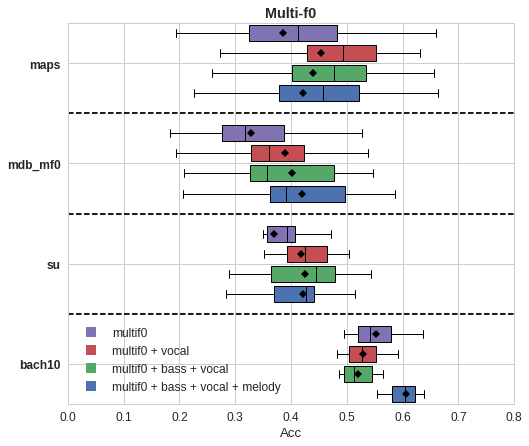

In [101]:
mf0 = '../experiment_output/multitask_singletask_mf0/evaluation/'
mf0_mel = '../experiment_output/multitask_mf0_melody/evaluation/'
mf0_bass = '../experiment_output/multitask_mf0_bass/evaluation/'
mf0_voc = '../experiment_output/multitask_mf0_vocal/evaluation/'
mf0_mel_bass = '../experiment_output/multitask_mf0_mel_bass/evaluation/'
mf0_mel_voc = '../experiment_output/multitask_mf0_mel_vocal/evaluation/'
mf0_bass_voc = '../experiment_output/multitask_mf0_voc_bass/evaluation/'
mf0_mel_bass_voc = '../experiment_output/multitask_base_experiment/evaluation/'

folder_list1 = [mf0, mf0_mel, mf0_bass, mf0_voc]
                #mf0_mel_bass, mf0_mel_voc, mf0_bass_voc, mf0_mel_bass_voc]
groups1 = ['multif0', 'multif0 + melody', 'multif0 + bass', 'multif0 + vocal']
           #'multif0 + melody + bass', 'multif0 + melody + vocal', 'multif0 + bass + vocal', 'all']
multif0_datapoints1, datasets_mf01 = get_task_datapoints(folder_list1, 'multif0', metric='Accuracy')

folder_list2 = [mf0_voc, mf0_mel_voc, mf0_bass_voc, mf0_mel_bass_voc]
groups2 = ['multif0 + vocal', 'multif0 + melody + vocal', 'multif0 + bass + vocal', 'all']
multif0_datapoints2, datasets_mf02 = get_task_datapoints(folder_list2, 'multif0', metric='Accuracy')

folder_list3 = [mf0_mel_bass_voc, mf0_bass_voc, mf0_voc, mf0]
groups3 = ['multif0 + bass + vocal + melody', 'multif0 + bass + vocal', 'multif0 + vocal', 'multif0']
multif0_datapoints3, datasets_mf03 = get_task_datapoints(folder_list3, 'multif0', metric='Accuracy')

plt.figure(figsize=(8, 7))
sns.set(font_scale=1.2)
sns.set_style('whitegrid')
# add_plot(131, datasets_mf01, groups1, multif0_datapoints1, 'Multi-f0',
#              show_yaxis=True, legend_loc=3, xlim=[0, 1.0])

# add_plot(132, datasets_mf02, groups2, multif0_datapoints2, 'Multi-f0',
#              show_yaxis=True, legend_loc=3, xlim=[0, 1.0])

add_plot(111, datasets_mf03, groups3, multif0_datapoints3, 'Multi-f0',
             show_yaxis=True, legend_loc=3, xlim=[0, 0.8], xlabel='Acc')

plt.savefig("../journal-paper-figs/multitask_by_subtask.pdf", format='pdf', bbox_inches='tight')

In [39]:
len(multif0_datapoints1)

16

1 y-groups
4 colors


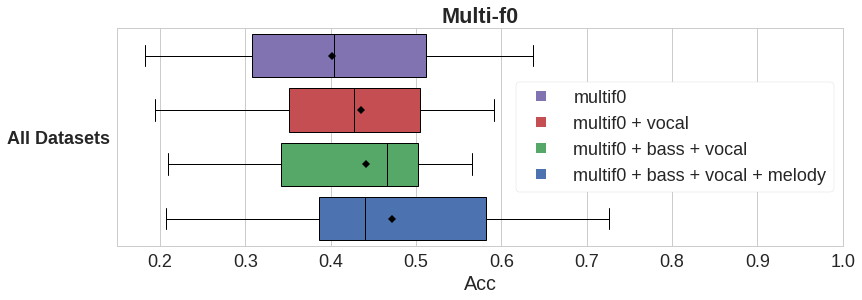

In [20]:
# same plot as above grouped into one big dataset, split by metric

mf0 = '../experiment_output/multitask_singletask_mf0/evaluation/'
mf0_mel = '../experiment_output/multitask_mf0_melody/evaluation/'
mf0_bass = '../experiment_output/multitask_mf0_bass/evaluation/'
mf0_voc = '../experiment_output/multitask_mf0_vocal/evaluation/'
mf0_mel_bass = '../experiment_output/multitask_mf0_mel_bass/evaluation/'
mf0_mel_voc = '../experiment_output/multitask_mf0_mel_vocal/evaluation/'
mf0_bass_voc = '../experiment_output/multitask_mf0_voc_bass/evaluation/'
mf0_mel_bass_voc = '../experiment_output/multitask_base_experiment/evaluation/'

# folder_list1 = [mf0, mf0_mel, mf0_bass, mf0_voc,
#                 mf0_mel_bass, mf0_mel_voc, mf0_bass_voc, mf0_mel_bass_voc]
# groups1 = ['multif0', 'multif0 + melody', 'multif0 + bass', 'multif0 + vocal', 
#            'multif0 + melody + bass', 'multif0 + melody + vocal', 'multif0 + bass + vocal', 'all']

folder_list3 = [mf0_mel_bass_voc, mf0_bass_voc, mf0_voc, mf0]
groups3 = ['multif0 + bass + vocal + melody', 'multif0 + bass + vocal', 'multif0 + vocal', 'multif0']

multif0_datapoints_accuracy = get_grouped_datapoints(folder_list3, 'multif0', metric='Accuracy')
multif0_datapoints_precision = get_grouped_datapoints(folder_list3, 'multif0', metric='Precision')
multif0_datapoints_recall = get_grouped_datapoints(folder_list3, 'multif0', metric='Recall')
#substitution

all_datapoints = []
# all_datapoints.extend(multif0_datapoints_precision)
# all_datapoints.extend(multif0_datapoints_recall)
all_datapoints.extend(multif0_datapoints_accuracy)
all_groups = ['All Datasets']

plt.figure(figsize=(13, 4))
sns.set(font_scale=1.8)
sns.set_style('whitegrid')
add_plot(111, all_groups, groups3, all_datapoints, 'Multi-f0',
             show_yaxis=True, legend_loc=5, xlim=[0.15, 1.0], xlabel='Acc')
plt.savefig("../journal-paper-figs/multitask_by_subtask_grouped.pdf", format='pdf', bbox_inches='tight')
#######################

# multif0_datapoints_suberr = get_grouped_datapoints(folder_list3, 'multif0', metric='Substitution Error')
# multif0_datapoints_misserr = get_grouped_datapoints(folder_list3, 'multif0', metric='Miss Error')
# multif0_datapoints_faerr = get_grouped_datapoints(folder_list3, 'multif0', metric='False Alarm Error')

# all_datapoints = []
# all_datapoints.extend(multif0_datapoints_suberr)
# all_datapoints.extend(multif0_datapoints_misserr)
# all_datapoints.extend(multif0_datapoints_faerr)
# all_groups = ['E$_{sub}$', 'miss', 'false alarm']

# plt.figure(figsize=(15, 7))
# add_plot(111, all_groups, groups3, all_datapoints, 'Multi-f0',
#              show_yaxis=True, legend_loc=0, xlim=[0, 1.0])


#########################
# folder_list1 = [mf0, mf0_mel, mf0_bass, mf0_voc]
#                 #mf0_mel_bass, mf0_mel_voc, mf0_bass_voc, mf0_mel_bass_voc]
# groups1 = ['multif0', 'multif0 + melody', 'multif0 + bass', 'multif0 + vocal']
#            #'multif0 + melody + bass', 'multif0 + melody + vocal', 'multif0 + bass + vocal', 'all']
# multif0_datapoints1 = get_grouped_datapoints(folder_list1, 'multif0', metric='Accuracy')

# folder_list2 = [mf0_voc, mf0_mel_voc, mf0_bass_voc, mf0_mel_bass_voc]
# groups2 = ['multif0 + vocal', 'multif0 + melody + vocal', 'multif0 + bass + vocal', 'all']
# multif0_datapoints2 = get_grouped_datapoints(folder_list2, 'multif0', metric='Accuracy')

# folder_list3 = [mf0, mf0_voc, mf0_bass_voc, mf0_mel_bass_voc]
# groups3 = ['multif0', 'multif0 + vocal', 'multif0 + bass + vocal', 'all']
# multif0_datapoints3 = get_grouped_datapoints(folder_list3, 'multif0', metric='Accuracy')

# metrics = ['Accuracy']

# plt.figure(figsize=(15, 5))
# add_plot(131, metrics, groups1, multif0_datapoints1, 'Multi-f0',
#              show_yaxis=True, legend_loc=0, xlim=[0, 1.0])

# add_plot(132, metrics, groups2, multif0_datapoints2, 'Multi-f0',
#              show_yaxis=True, legend_loc=0, xlim=[0, 1.0])

# add_plot(133, metrics, groups3, multif0_datapoints3, 'Multi-f0',
#              show_yaxis=True, legend_loc=0, xlim=[0, 1.0])

# Do more harmonics help?

4 y-groups
5 colors
3 y-groups
5 colors
1 y-groups
5 colors
1 y-groups
5 colors


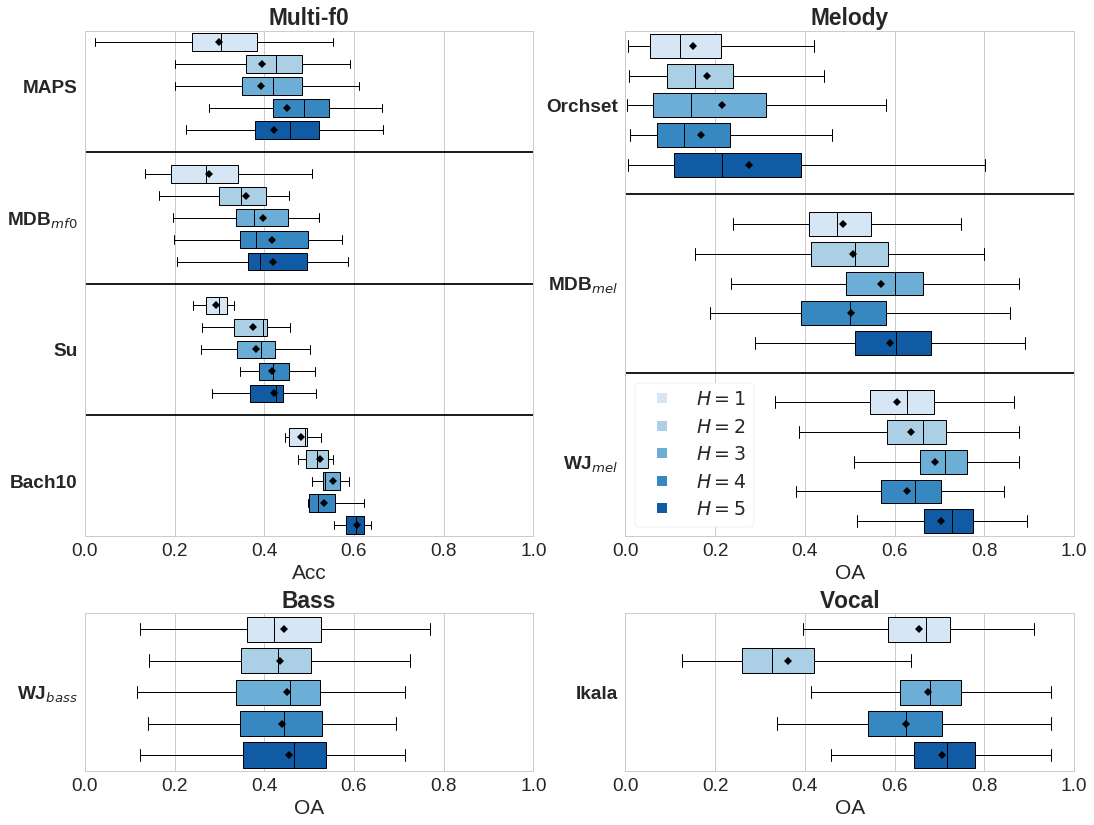

In [21]:
folder_list = [harms_5_dir, harms_4_dir, harms_3_dir, harms_2_dir, harms_1_dir]
label_list = ['$H=5$', '$H=4$', '$H=3$', '$H=2$', '$H=1$']

multif0_datapoints, datasets_mf0 = get_task_datapoints(folder_list, 'multif0', metric='Accuracy')
melody_datapoints, datasets_mel = get_task_datapoints(folder_list, 'melody', metric='Overall Accuracy')
bass_datapoints, datasets_bass = get_task_datapoints(folder_list, 'bass', metric='Overall Accuracy')
vocal_datapoints, datasets_vocal = get_task_datapoints(folder_list, 'vocal', metric='Overall Accuracy')

plt.figure(figsize=(15, 16))
sns.set(font_scale=1.9)
sns.set_style('whitegrid')
add_plot(221, datasets_mf0, label_list, multif0_datapoints, 'Multi-f0',
             show_yaxis=True, legend_loc=None, xlim=[0, 1.0], color_palette='Blues_r',
        xlabel='Acc')

add_plot(222, datasets_mel, label_list, melody_datapoints, 'Melody',
             show_yaxis=True, legend_loc=3, xlim=[0, 1.0], color_palette='Blues_r',
        xlabel='OA')

add_plot(627, datasets_bass, label_list, bass_datapoints, 'Bass',
             show_yaxis=True, legend_loc=None, xlim=[0, 1.0], color_palette='Blues_r',
        xlabel='OA')

add_plot(628, datasets_vocal, label_list, vocal_datapoints, 'Vocal',
             show_yaxis=True, legend_loc=None, xlim=[0, 1.0], color_palette='Blues_r',
        xlabel='OA')

plt.tight_layout(pad=0.0, w_pad=0.0, h_pad=-1.5)


plt.savefig("../journal-paper-figs/num_harmonics.pdf", format='pdf', bbox_inches='tight')

4 y-groups
5 colors
3 y-groups
5 colors
1 y-groups
5 colors
1 y-groups
5 colors


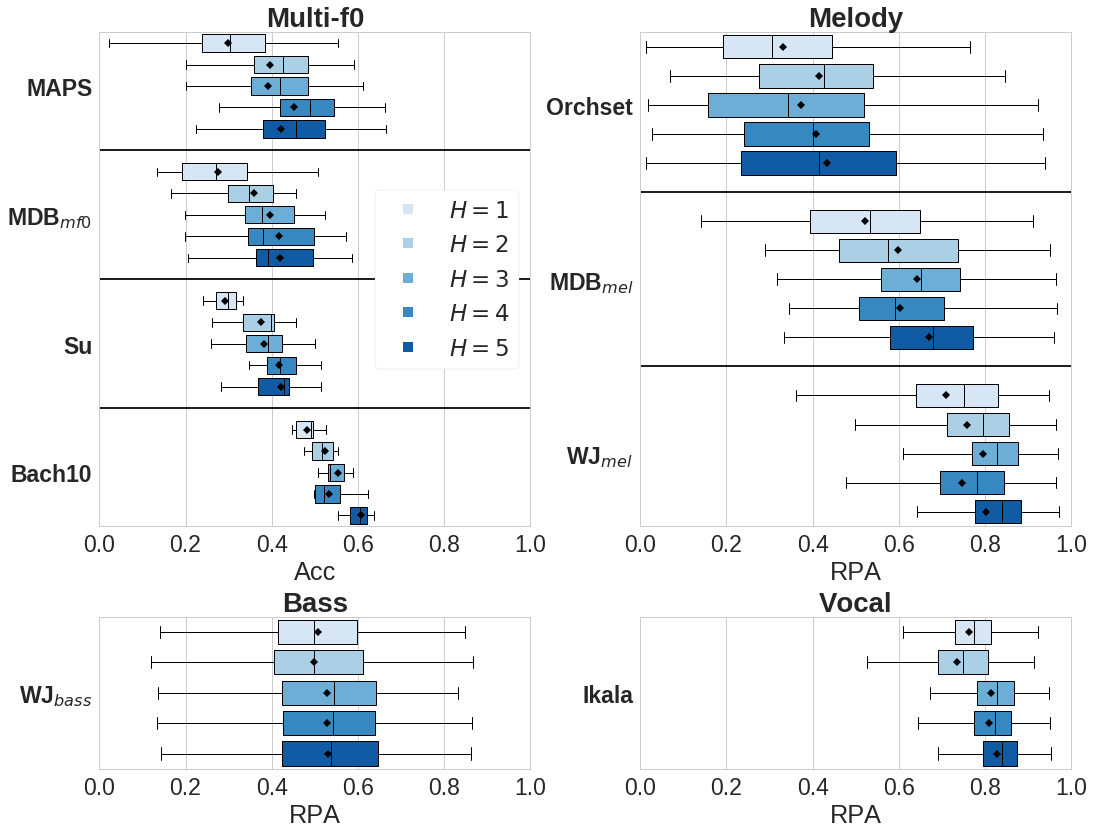

In [140]:
folder_list = [harms_5_dir, harms_4_dir, harms_3_dir, harms_2_dir, harms_1_dir]
label_list = ['$H=5$', '$H=4$', '$H=3$', '$H=2$', '$H=1$']

multif0_datapoints, datasets_mf0 = get_task_datapoints(folder_list, 'multif0', metric='Accuracy')
melody_datapoints, datasets_mel = get_task_datapoints(folder_list, 'melody', metric='Raw Pitch Accuracy')
bass_datapoints, datasets_bass = get_task_datapoints(folder_list, 'bass', metric='Raw Pitch Accuracy')
vocal_datapoints, datasets_vocal = get_task_datapoints(folder_list, 'vocal', metric='Raw Pitch Accuracy')

plt.figure(figsize=(15, 16))
sns.set(font_scale=2.3)
sns.set_style('whitegrid')
add_plot(221, datasets_mf0, label_list, multif0_datapoints, 'Multi-f0',
             show_yaxis=True, legend_loc=7, xlim=[0, 1.0], color_palette='Blues_r',
        xlabel='Acc')

add_plot(222, datasets_mel, label_list, melody_datapoints, 'Melody',
             show_yaxis=True, legend_loc=None, xlim=[0, 1.0], color_palette='Blues_r',
        xlabel='RPA')

add_plot(627, datasets_bass, label_list, bass_datapoints, 'Bass',
             show_yaxis=True, legend_loc=None, xlim=[0, 1.0], color_palette='Blues_r',
        xlabel='RPA')

add_plot(628, datasets_vocal, label_list, vocal_datapoints, 'Vocal',
             show_yaxis=True, legend_loc=None, xlim=[0, 1.0], color_palette='Blues_r',
        xlabel='RPA')

plt.tight_layout(pad=0.0, w_pad=0.0, h_pad=-1.5)


plt.savefig("../journal-paper-figs/num_harmonics_rpa.pdf", format='pdf', bbox_inches='tight')

1 y-groups
5 colors
1 y-groups
5 colors
1 y-groups
5 colors
1 y-groups
5 colors


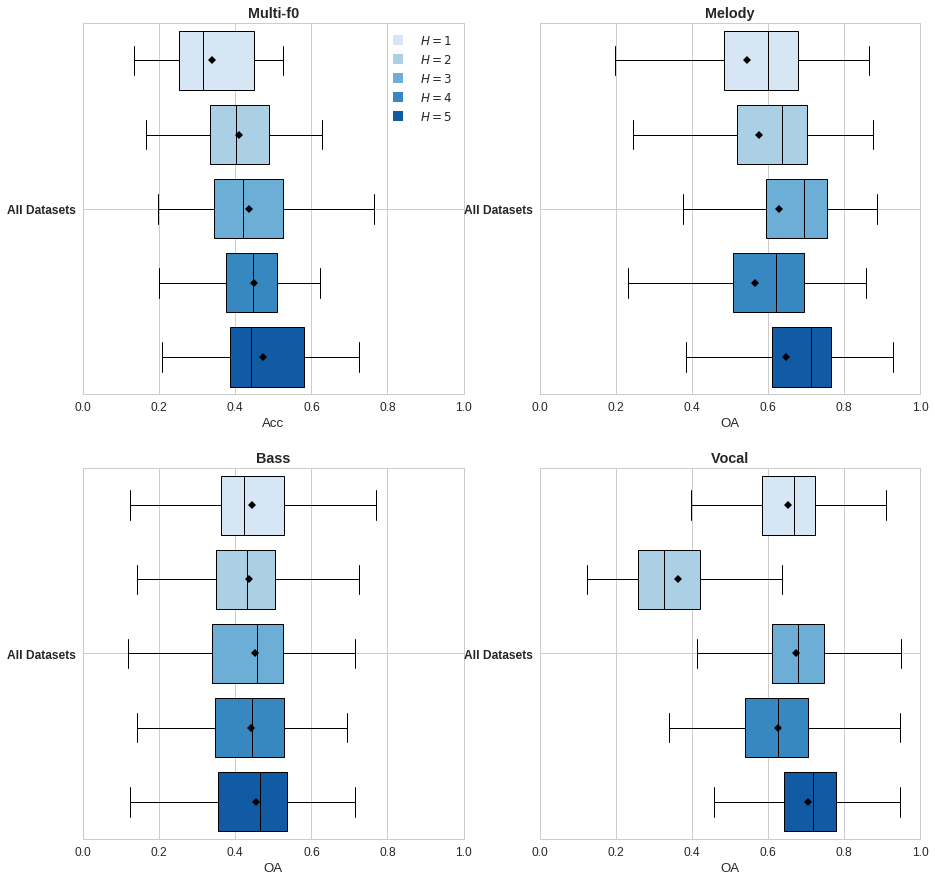

In [112]:
# same plot, grouped by dataset for many metrics

# multif0
folder_list = [harms_5_dir, harms_4_dir, harms_3_dir, harms_2_dir, harms_1_dir]
label_list = ['$H=5$', '$H=4$', '$H=3$', '$H=2$', '$H=1$']

mf0_metrics = ['Accuracy']#, 'Chroma Accuracy']
all_mf0_datapoints = []
for metric in mf0_metrics:
    multif0_datapoints = get_grouped_datapoints(folder_list, 'multif0', metric=metric)
    all_mf0_datapoints.extend(multif0_datapoints)
    
sf0_metrics = ['Overall Accuracy']#, 'Raw Pitch Accuracy', 'Raw Chroma Accuracy']
sf0_names = ['OA']#, 'RPA', 'RCA']
all_mel_datapoints = []
all_bass_datapoints = []
all_voc_datapoints = []
for metric in sf0_metrics:
    mel_datapoints = get_grouped_datapoints(folder_list, 'melody', metric=metric)
    bass_datapoints = get_grouped_datapoints(folder_list, 'bass', metric=metric)
    vocal_datapoints = get_grouped_datapoints(folder_list, 'vocal', metric=metric)

    all_mel_datapoints.extend(mel_datapoints)
    all_bass_datapoints.extend(bass_datapoints)
    all_voc_datapoints.extend(vocal_datapoints)
    
plt.figure(figsize=(15, 15))
sns.set(font_scale=1.2)
sns.set_style('whitegrid')
add_plot(221, ['All Datasets'], label_list, all_mf0_datapoints, 'Multi-f0',
         show_yaxis=True, legend_loc=0, xlim=[0, 1.0], color_palette='Blues_r',
         xlabel='Acc')

add_plot(222, ['All Datasets'], label_list, all_mel_datapoints, 'Melody',
         show_yaxis=True, legend_loc=None, xlim=[0, 1.0], color_palette='Blues_r',
        xlabel='OA')

add_plot(223, ['All Datasets'], label_list, all_bass_datapoints, 'Bass',
         show_yaxis=True, legend_loc=None, xlim=[0, 1.0], color_palette='Blues_r',
        xlabel='OA')

add_plot(224, ['All Datasets'], label_list, all_voc_datapoints, 'Vocal',
         show_yaxis=True, legend_loc=None, xlim=[0, 1.0], color_palette='Blues_r',
         xlabel='OA')

# Does adding piano & guitar as additional tasks help?

4 y-groups
4 colors
3 y-groups
4 colors
1 y-groups
4 colors
1 y-groups
4 colors


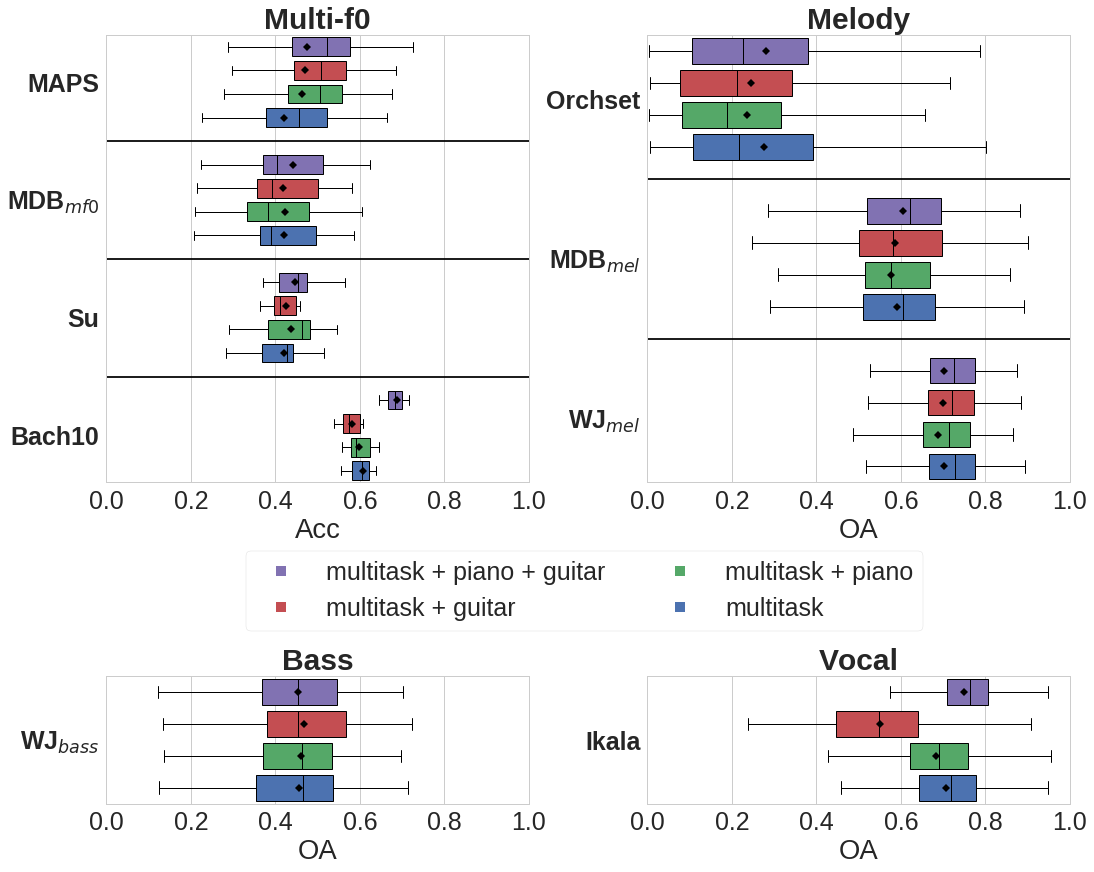

In [136]:
folder_list = [multitask_dir, mf0_piano, mf0_guitar, mf0_piano_guitar]
label_list = ['multitask', 'multitask + piano', 'multitask + guitar', 'multitask + piano + guitar']

# folder_list = [multitask_dir, mf0_guitar]
# label_list = ['multitask', 'multitask + guitar']

multif0_datapoints, datasets_mf0 = get_task_datapoints(folder_list, 'multif0', metric='Accuracy')
melody_datapoints, datasets_mel = get_task_datapoints(folder_list, 'melody', metric='Overall Accuracy')
bass_datapoints, datasets_bass = get_task_datapoints(folder_list, 'bass', metric='Overall Accuracy')
vocal_datapoints, datasets_vocal = get_task_datapoints(folder_list, 'vocal', metric='Overall Accuracy')

plt.figure(figsize=(15, 17))
sns.set(font_scale=2.5)
sns.set_style('whitegrid')
add_plot(221, datasets_mf0, label_list, multif0_datapoints, 'Multi-f0',
             show_yaxis=True, legend_loc=3, xlim=[0, 1.0], xlabel='Acc',
         bbox_to_anchor=(0.3, -0.36), ncol=2)

add_plot(222, datasets_mel, label_list, melody_datapoints, 'Melody',
             show_yaxis=True, legend_loc=None, xlim=[0, 1.0], xlabel='OA')

add_plot(627, datasets_bass, label_list, bass_datapoints, 'Bass',
             show_yaxis=True, legend_loc=None, xlim=[0, 1.0], xlabel='OA')

add_plot(628, datasets_vocal, label_list, vocal_datapoints, 'Vocal',
             show_yaxis=True, legend_loc=None, xlim=[0, 1.0], xlabel='OA')

plt.tight_layout(pad=0.0, w_pad=0.0, h_pad=-0.1)


plt.savefig("../journal-paper-figs/extra_tasks.pdf", format='pdf', bbox_inches='tight')

# Mutif0 comparison

In [99]:
def get_mf0_dfbox(metrics, multitask_path, singletask_path, benetos_path, duan_path):
    df_multitask = pd.DataFrame.from_csv(multitask_path)
    df_singletask = pd.DataFrame.from_csv(singletask_path)
    df_benetos = pd.DataFrame.from_csv(benetos_path)
    df_duan = pd.DataFrame.from_csv(duan_path)
    
    boxdata = []
    for metric in metrics:
        boxdata.extend([
            df_multitask[metric],
            df_singletask[metric],
            df_benetos[metric],
            df_duan[metric]
        ])

    dfbox = pd.DataFrame(np.array(boxdata).T)
    return dfbox

def add_mf0_plot(subplot_tuple, metrics, dfbox, title, show_yaxis=True, legend_loc=None,
                 xlim=None, xlabel='Score', bbox_to_anchor=None, ncol=1):
    plt.subplot(subplot_tuple)
    plt.title(title, weight='bold')
    n_algs = 4
    n_metrics = len(metrics)
    positions = []
    dotted_line_positions = []
    k = 1
    for i in range(n_metrics):
        for j in range(n_algs):
            positions.append(k)
            k = k + 1
        dotted_line_positions.append(k)
        k = k + 1
    
    current_palette = sns.color_palette(None, 4)
    colors = current_palette*n_metrics

    box = plt.boxplot(
        dfbox.values, widths=0.8, positions=positions,
        patch_artist=True, showmeans=True,
        medianprops={'color': 'k'},
        meanprops=dict(marker='D', markeredgecolor='black',
            markerfacecolor='k'),
        vert=False
    )
    for patch, color in zip(box['boxes'], colors):
        patch.set_facecolor(color)

    plt.xlabel(xlabel)
    yticks = [np.mean(positions[i: i + n_algs]) for i in range(0, len(positions), 4)]

    if show_yaxis:
        plt.yticks(yticks, metrics, rotation='horizontal')
    else:
        plt.yticks(yticks, ['']*len(metrics), rotation='horizontal')

    for i in dotted_line_positions:
        if i < positions[-1]:
            plt.plot([-1, 2], [i, i], '-', color='k')

    if xlim is not None:
        plt.xlim(xlim)
    
    plt.grid(axis='y')
    
    if legend_loc is not None:
        h_mtask, = plt.plot([1,1],'s',color=colors[0], markersize=10)
        h_stask, = plt.plot([1,1],'s',color=colors[1], markersize=10)
        h_benetos, = plt.plot([1,1],'s',color=colors[2], markersize=10)
        h_duan, = plt.plot([1,1],'s',color=colors[3], markersize=10)
        
        lgd = plt.legend(
            (h_duan, h_benetos, h_stask, h_mtask),
            ('Duan', 'Benetos', 'Singletask', 'Multitask'), ncol=ncol,
            loc=legend_loc, frameon=True, framealpha=1, bbox_to_anchor=bbox_to_anchor)

        h_benetos.set_visible(False)
        h_duan.set_visible(False)
        h_stask.set_visible(False)
        h_mtask.set_visible(False)

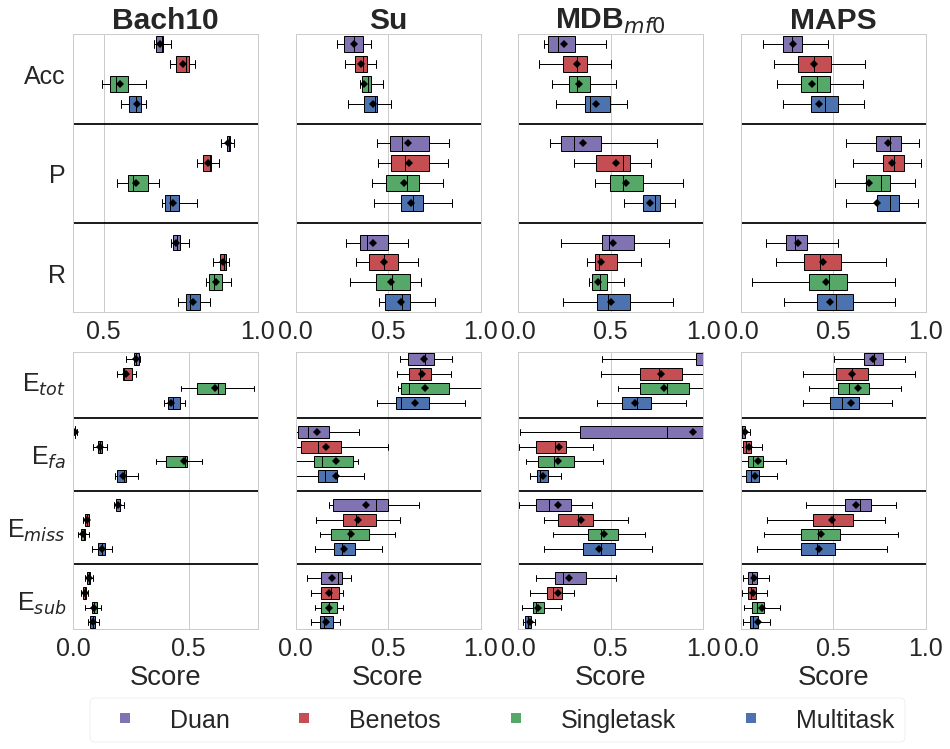

In [118]:
metrics = ['Recall', 'Precision', 'Accuracy']
metrics_err = ['Substitution Error', 'Miss Error', 'False Alarm Error', 'Total Error']

metrics_lab = ['R', 'P', 'Acc']
metrics_lab_err = ['E$_{sub}$', 'E$_{miss}$', 'E$_{fa}$', 'E$_{tot}$']

benetos_bach10_path = "../outputs/bach10_benetos_all_scores.csv"
duan_bach10_path = "../outputs/bach10_duan_all_scores.csv"
stask_bach10_path = '../experiment_output/multitask_singletask_mf0/evaluation/bach10_scores.csv'
mtask_bach10_path = '../experiment_output/multitask_base_experiment/evaluation/bach10_scores.csv'
df_bach10 = get_mf0_dfbox(metrics, mtask_bach10_path, stask_bach10_path, benetos_bach10_path, duan_bach10_path)
df_bach10_err = get_mf0_dfbox(metrics_err, mtask_bach10_path, stask_bach10_path, benetos_bach10_path, duan_bach10_path)

benetos_su_path = "../outputs/su_benetos_all_scores.csv"
duan_su_path = "../outputs/su_duan_all_scores.csv"
stask_su_path = '../experiment_output/multitask_singletask_mf0/evaluation/su_scores.csv'
mtask_su_path = '../experiment_output/multitask_base_experiment/evaluation/su_scores.csv'
df_su = get_mf0_dfbox(metrics, mtask_su_path, stask_su_path, benetos_su_path, duan_su_path)
df_su_err = get_mf0_dfbox(metrics_err, mtask_su_path, stask_su_path, benetos_su_path, duan_su_path)

benetos_mdb_path = "../outputs/mdb_test_benetos_all_scores-Copy1.csv"
duan_mdb_path = "../outputs/mdb_test_duan_all_scores-Copy1.csv"
stask_mdb_path = '../experiment_output/multitask_singletask_mf0/evaluation/mdb_mf0_scores.csv'
mtask_mdb_path = '../experiment_output/multitask_base_experiment/evaluation/mdb_mf0_scores.csv'
df_mdb = get_mf0_dfbox(metrics, mtask_mdb_path, stask_mdb_path, benetos_mdb_path, duan_mdb_path)
df_mdb_err = get_mf0_dfbox(metrics_err, mtask_mdb_path, stask_mdb_path, benetos_mdb_path, duan_mdb_path)

benetos_maps_path = "../outputs/maps_benetos_all_scores.csv"
duan_maps_path = "../outputs/maps_duan_all_scores.csv"
stask_maps_path = '../experiment_output/multitask_singletask_mf0/evaluation/maps_scores.csv'
mtask_maps_path = '../experiment_output/multitask_base_experiment/evaluation/maps_scores.csv'
df_maps = get_mf0_dfbox(metrics, mtask_maps_path, stask_maps_path, benetos_maps_path, duan_maps_path)
df_maps_err = get_mf0_dfbox(metrics_err, mtask_maps_path, stask_maps_path, benetos_maps_path, duan_maps_path)

fig = plt.figure(figsize=(13, 9.5))
sns.set(font_scale=2.5)
sns.set_style('whitegrid')

add_mf0_plot(241, metrics_lab, df_bach10, 'Bach10', xlim=[0.4, 1.0], legend_loc=None)
plt.xlabel('')
add_mf0_plot(242, metrics_lab, df_su, 'Su', show_yaxis=False, xlim=[0.0, 1.0])
plt.xlabel('')
add_mf0_plot(243, metrics_lab, df_mdb, 'MDB$_{mf0}$', xlim=[0.0, 1.0], show_yaxis=False)
plt.xlabel('')
add_mf0_plot(244, metrics_lab, df_maps, 'MAPS', xlim=[0.0, 1.0], show_yaxis=False)
plt.xlabel('')

add_mf0_plot(245, metrics_lab_err, df_bach10_err, '', xlim=[0.0, 0.8])
add_mf0_plot(246, metrics_lab_err, df_su_err, '', show_yaxis=False, xlim=[0.0, 1.0],
             legend_loc=4, bbox_to_anchor=(3.36, -0.45), ncol=4)
add_mf0_plot(247, metrics_lab_err, df_mdb_err, '', xlim=[0.0, 1.0], show_yaxis=False)
add_mf0_plot(248, metrics_lab_err, df_maps_err, '', xlim=[0.0, 1.0], show_yaxis=False)

plt.tight_layout(pad=0.0, w_pad=0.1, h_pad=0.3)

plt.savefig("../journal-paper-figs/mf0_vs_sota.pdf", format='pdf', bbox_inches='tight')

## Melody Comparison

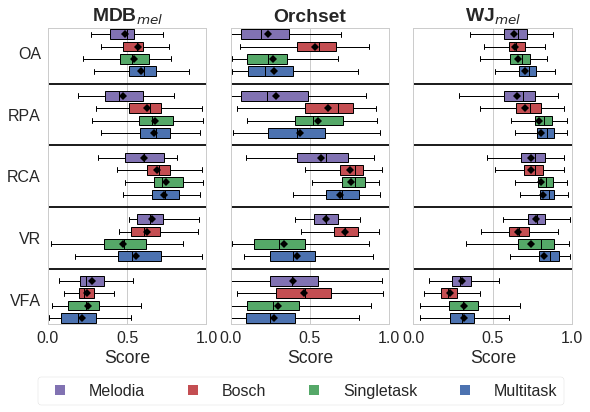

In [128]:
def get_mel_dfbox(metrics, multitask_path, singletask_path, melodia_path, juanjo_path):
    df_multitask = pd.DataFrame.from_csv(multitask_path)
    df_singletask = pd.DataFrame.from_csv(singletask_path)
    df_melodia = pd.DataFrame.from_csv(melodia_path)
    df_juanjo = pd.DataFrame.from_csv(juanjo_path)
    
    boxdata = []
    for metric in metrics:
        boxdata.extend([
            df_multitask[metric],
            df_singletask[metric],
            df_juanjo[metric],
            df_melodia[metric]
        ])

    dfbox = pd.DataFrame(np.array(boxdata).T)
    return dfbox

def add_mel_plot(subplot_tuple, metrics, dfbox, title, show_yaxis=True, legend_loc=None,
                 xlim=None, xlabel='Score', bbox_to_anchor=None, ncol=1):
    plt.subplot(subplot_tuple)
    plt.title(title, weight='bold')
    n_algs = 4
    n_metrics = len(metrics)
    dotted_line_positions = []
    positions = []
    k = 1
    for i in range(n_metrics):
        for j in range(n_algs):
            positions.append(k)
            k = k + 1
        dotted_line_positions.append(k)
        k = k + 1
    
    current_palette = sns.color_palette(None, 4)
    colors = current_palette*n_metrics

    box = plt.boxplot(
        dfbox.values, widths=0.8, positions=positions,
        patch_artist=True, showmeans=True,
        medianprops={'color': 'k'},
        meanprops=dict(marker='D', markeredgecolor='black',
            markerfacecolor='k'),
        vert=False
    )
    for patch, color in zip(box['boxes'], colors):
        patch.set_facecolor(color)

    plt.xlabel(xlabel)
    yticks = [np.mean(positions[i: i + n_algs]) for i in range(0, len(positions), 4)]

    if show_yaxis:
        plt.yticks(yticks, metrics, rotation='horizontal')
    else:
        plt.yticks(yticks, ['']*len(metrics), rotation='horizontal')

    for i in dotted_line_positions:
        if i < positions[-1]:
            plt.plot([-1, 2], [i, i], '-', color='k')
        
    if xlim is not None:
        plt.xlim(xlim)
        
    plt.grid(axis='y')
        
    if legend_loc is not None:
        h_mtask, = plt.plot([1,1],'s',color=colors[0], markersize=10)
        h_stask, = plt.plot([1,1],'s',color=colors[1], markersize=10)
        h_bosch, = plt.plot([1,1],'s',color=colors[2], markersize=10)
        h_melodia, = plt.plot([1,1],'s',color=colors[3], markersize=10)
        
        lgd = plt.legend(
            (h_melodia, h_bosch, h_stask, h_mtask),
            ('Melodia', 'Bosch', 'Singletask', 'Multitask'), ncol=ncol, loc=legend_loc,
            frameon=True, framealpha=1, bbox_to_anchor=bbox_to_anchor)

        h_melodia.set_visible(False)
        h_bosch.set_visible(False)
        h_stask.set_visible(False)
        h_mtask.set_visible(False)

metrics = [
    'Voicing False Alarm', 'Voicing Recall',
    'Raw Chroma Accuracy', 'Raw Pitch Accuracy',
    'Overall Accuracy'
]

metrics_lab = ['VFA', 'VR', 'RCA', 'RPA', 'OA']

melodia_mdb_path = "../outputs/melody_comparisons/melodia_mdb_scores.csv"
bosch_mdb_path = "../outputs/melody_comparisons/juanjo_mdb_scores.csv"
stask_mdb_path = "../experiment_output/multitask_singletask_mel/evaluation/mdb_mel_scores.csv"
mtask_mdb_path = "../experiment_output/multitask_base_experiment/evaluation/mdb_mel_scores.csv"
df_mdb = get_mel_dfbox(
    metrics, mtask_mdb_path, stask_mdb_path, melodia_mdb_path, bosch_mdb_path)

melodia_orchset_path = "../outputs/orchset_melodia_all_scores.csv"
bosch_orchset_path = "../outputs/melody_comparisons/juanjo_orchset_BG2_scores.csv"
stask_orchset_path = "../experiment_output/multitask_singletask_mel/evaluation/orchset_scores.csv"
mtask_orchset_path = "../experiment_output/multitask_base_experiment/evaluation/orchset_scores.csv"
df_orchset = get_mel_dfbox(
    metrics, mtask_orchset_path, stask_orchset_path, melodia_orchset_path, bosch_orchset_path)

melodia_wjmel_path = "../outputs/wjmel_melodia_all_scores.csv"
bosch_wjmel_path = "../outputs/wjmel_bosch_all_scores.csv"
stask_wjmel_path = "../experiment_output/multitask_singletask_mel/evaluation/wj_mel_scores.csv"
mtask_wjmel_path = "../experiment_output/multitask_base_experiment/evaluation/wj_mel_scores.csv"
df_wjmel = get_mel_dfbox(
    metrics, mtask_wjmel_path, stask_wjmel_path, melodia_wjmel_path, bosch_wjmel_path)

fig = plt.figure(figsize=(8, 5))
sns.set(font_scale=1.6)
sns.set_style('whitegrid')

add_mel_plot(131, metrics_lab, df_mdb, 'MDB$_{mel}$', xlim=[0, 1])
add_mel_plot(132, metrics_lab, df_orchset, 'Orchset', xlim=[0, 1], show_yaxis=False)
add_mel_plot(133, metrics_lab, df_wjmel, 'WJ$_{mel}$', xlim=[0, 1], show_yaxis=False,
            legend_loc=4, bbox_to_anchor=(1.0, -0.3), ncol=4)

plt.tight_layout(pad=0.0, w_pad=0.1, h_pad=0.0)

plt.savefig("../journal-paper-figs/mel_vs_sota.pdf", format='pdf', bbox_inches='tight')

## Vocal Comparison

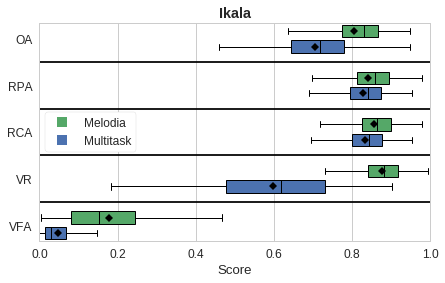

In [77]:
def get_voc_dfbox(metrics, multitask_path, melodia_path):
    df_multitask = pd.DataFrame.from_csv(multitask_path)
    df_melodia = pd.DataFrame.from_csv(melodia_path)
    
    boxdata = []
    for metric in metrics:
        boxdata.extend([
            df_multitask[metric],
            df_melodia[metric]
        ])

    dfbox = pd.DataFrame(np.array(boxdata).T)
    return dfbox

def add_voc_plot(subplot_tuple, metrics, dfbox, title, show_yaxis=True, legend_loc=None,
                 xlim=None, xlabel='Score', bbox_to_anchor=None):
    plt.subplot(subplot_tuple)
    plt.title(title, weight='bold')
    n_algs = 2
    n_metrics = len(metrics)
    dotted_line_positions = []
    positions = []
    k = 1
    for i in range(n_metrics):
        for j in range(n_algs):
            positions.append(k)
            k = k + 1
        dotted_line_positions.append(k)
        k = k + 1
    
    current_palette = sns.color_palette(None, n_algs)
    colors = current_palette*n_metrics

    box = plt.boxplot(
        dfbox.values, widths=0.8, positions=positions,
        patch_artist=True, showmeans=True,
        medianprops={'color': 'k'},
        meanprops=dict(marker='D', markeredgecolor='black',
            markerfacecolor='k'),
        vert=False
    )
    for patch, color in zip(box['boxes'], colors):
        patch.set_facecolor(color)

    plt.xlabel(xlabel)
    yticks = [np.mean(positions[i: i + n_algs]) for i in range(0, len(positions), n_algs)]

    if show_yaxis:
        plt.yticks(yticks, metrics, rotation='horizontal')
    else:
        plt.yticks(yticks, ['']*len(metrics), rotation='horizontal')

    for i in dotted_line_positions:
        if i < positions[-1]:
            plt.plot([-1, 2], [i, i], '-', color='k')
        
    if xlim is not None:
        plt.xlim(xlim)
    
    plt.grid(axis='y')
    
    if legend_loc is not None:
        h_mtask, = plt.plot([1,1],'s',color=colors[0], markersize=10)
        h_melodia, = plt.plot([1,1],'s',color=colors[1], markersize=10)
        
        lgd = plt.legend(
            (h_melodia, h_mtask),
            ('Melodia', 'Multitask'), ncol=1, loc=legend_loc,
            frameon=True, framealpha=1, bbox_to_anchor=bbox_to_anchor)

        h_melodia.set_visible(False)
        h_mtask.set_visible(False)

metrics = [
    'Voicing False Alarm', 'Voicing Recall',
    'Raw Chroma Accuracy', 'Raw Pitch Accuracy',
    'Overall Accuracy'
]

metrics_lab = ['VFA', 'VR', 'RCA', 'RPA', 'OA']

melodia_ikala_path = "../outputs/ikala_melodia_all_scores.csv"
mtask_ikala_path = "../experiment_output/multitask_base_experiment/evaluation/ikala_scores.csv"
df_ikala = get_voc_dfbox(metrics, mtask_ikala_path, melodia_ikala_path)

fig = plt.figure(figsize=(7, 4))
sns.set(font_scale=1.2)
sns.set_style('whitegrid')

add_voc_plot(111, metrics_lab, df_ikala, 'Ikala', xlim=[0, 1], legend_loc=0)

# plt.tight_layout(pad=0.0, w_pad=0.0, h_pad=0.0)

plt.savefig("../journal-paper-figs/voc_vs_sota.pdf", format='pdf', bbox_inches='tight')

## Bass Comparison

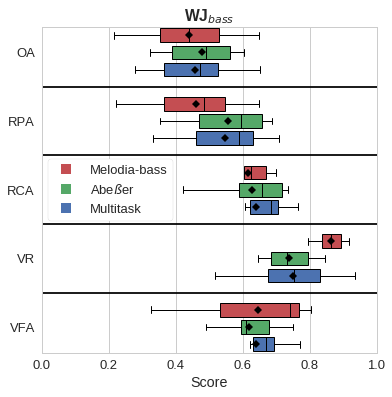

In [85]:
def get_bass_dfbox(metrics, multitask_path, abesser_path, melodia_path):
    df_multitask = pd.DataFrame.from_csv(multitask_path)
    df_abesser = pd.DataFrame.from_csv(abesser_path)
    df_melodia = pd.DataFrame.from_csv(melodia_path)
    
    boxdata = []
    for metric in metrics:
        boxdata.extend([
            df_multitask[metric],
            df_abesser[metric],
            df_melodia[metric]
        ])

    dfbox = pd.DataFrame(np.array(boxdata).T)
    return dfbox

def add_bass_plot(subplot_tuple, metrics, dfbox, title, show_yaxis=True, legend_loc=None,
                  xlim=None, xlabel='Score', bbox_to_anchor=None):
    plt.subplot(subplot_tuple)
    plt.title(title, weight='bold')
    n_algs = 3
    n_metrics = len(metrics)
    dotted_line_positions = []
    positions = []
    k = 1
    for i in range(n_metrics):
        for j in range(n_algs):
            positions.append(k)
            k = k + 1
        dotted_line_positions.append(k)
        k = k + 1
    
    current_palette = sns.color_palette(None, n_algs)
    colors = current_palette*n_metrics

    box = plt.boxplot(
        dfbox.values, widths=0.8, positions=positions,
        patch_artist=True, showmeans=True,
        medianprops={'color': 'k'},
        meanprops=dict(marker='D', markeredgecolor='black',
            markerfacecolor='k'),
        vert=False
    )
    for patch, color in zip(box['boxes'], colors):
        patch.set_facecolor(color)

    plt.xlabel(xlabel)
    yticks = [np.mean(positions[i: i + n_algs]) for i in range(0, len(positions), n_algs)]

    if show_yaxis:
        plt.yticks(yticks, metrics, rotation='horizontal')
    else:
        plt.yticks(yticks, ['']*len(metrics), rotation='horizontal')

    for i in dotted_line_positions:
        if i < positions[-1]:
            plt.plot([-1, 2], [i, i], '-', color='k')
        
    if xlim is not None:
        plt.xlim(xlim)
        
    plt.grid(axis='y')
        
    if legend_loc is not None:
        h_mtask, = plt.plot([1,1],'s',color=colors[0], markersize=10)
        h_abesser, = plt.plot([1, 1], 's', color=colors[1], markersize=10)
        h_melodia, = plt.plot([1,1],'s',color=colors[2], markersize=10)
        
        lgd = plt.legend(
            (h_melodia, h_abesser, h_mtask),
            ('Melodia-bass', 'Abe${\ss}$er', 'Multitask'), ncol=1, loc=legend_loc,
            frameon=True, framealpha=1, bbox_to_anchor=bbox_to_anchor)

        h_melodia.set_visible(False)
        h_abesser.set_visible(False)
        h_mtask.set_visible(False)

metrics = [
    'Voicing False Alarm', 'Voicing Recall',
    'Raw Chroma Accuracy', 'Raw Pitch Accuracy',
    'Overall Accuracy'
]

metrics_lab = ['VFA', 'VR', 'RCA', 'RPA', 'OA']

melodia_wjb_path = "../outputs/wjbass_melodia-bass_all_scores.csv"
abesser_wjb_path = "../outputs/wjbass_abesser_all_scores.csv"
mtask_wjb_path = "../experiment_output/multitask_base_experiment/evaluation/wj_bass_scores_subset.csv"
df_wjb = get_bass_dfbox(metrics, mtask_wjb_path, abesser_wjb_path, melodia_wjb_path)

fig = plt.figure(figsize=(6, 6))
sns.set(font_scale=1.3)
sns.set_style('whitegrid')

add_bass_plot(111, metrics_lab, df_wjb, 'WJ$_{bass}$', xlim=[0, 1], legend_loc=6)

# plt.tight_layout(pad=0.0, w_pad=0.0, h_pad=0.0)

plt.savefig("../journal-paper-figs/bass_vs_sota.pdf", format='pdf', bbox_inches='tight')

## Significance testing

In [24]:
import scipy.stats as stats

In [18]:
df_wjb

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,0.678797,0.692557,0.752427,0.709142,0.721425,0.834899,0.676844,0.462247,0.477561,0.657430,0.404723,0.337994,0.473405,0.357132,0.336527
1,0.681230,0.610734,0.707727,0.690528,0.847308,0.871661,0.426441,0.728824,0.678617,0.370411,0.633267,0.535495,0.316920,0.564902,0.491489
2,0.389670,0.751781,0.327791,0.517157,0.803641,0.917366,0.606158,0.725027,0.771309,0.424786,0.672065,0.648067,0.346323,0.592511,0.649212
3,0.304038,0.489804,0.785121,0.796962,0.681793,0.831757,0.705875,0.617406,0.605584,0.609942,0.569935,0.445253,0.564189,0.505424,0.400542
4,0.658605,0.491664,0.750245,0.628731,0.645450,0.896216,0.674754,0.648897,0.603401,0.584179,0.461320,0.256817,0.427180,0.369656,0.255476
5,0.698402,0.633079,0.774844,0.839497,0.746077,0.795632,0.693402,0.579793,0.623199,0.569331,0.496008,0.477746,0.528291,0.452010,0.448281
6,0.772281,0.598253,0.733139,0.804474,0.778503,0.846982,0.703710,0.691317,0.646311,0.591943,0.668020,0.493823,0.473835,0.555325,0.433286
7,0.659247,0.595353,0.350962,0.672815,0.802507,0.855287,0.391195,0.734375,0.698492,0.332345,0.688681,0.627998,0.278312,0.604847,0.630140
8,0.622596,0.607449,0.805651,0.899346,0.669192,0.919082,0.765352,0.421168,0.423144,0.709484,0.354194,0.221783,0.652007,0.322440,0.216183
9,0.923052,0.706625,0.472485,0.936438,0.688722,0.882811,0.748607,0.669901,0.625790,0.637909,0.621526,0.550066,0.526470,0.478040,0.543402


In [26]:
print(list(df_wjb[2]))
print(list(df_wjb))

[0.7524271844660001,
 0.70772712576800001,
 0.32779097387200001,
 0.78512084592099995,
 0.75024517816300007,
 0.774843641418,
 0.73313925279000003,
 0.35096153846199996,
 0.80565068493200009,
 0.47248510340000005]

### Multitask vs. Singletask

In [35]:
multif0_datapoints, datasets_mf0 = get_task_datapoints([multitask_dir, multif0_dir],'multif0', metric='Accuracy')
melody_datapoints, datasets_mel = get_task_datapoints([multitask_dir, melody_dir], 'melody', metric='Overall Accuracy')
bass_datapoints, datasets_bass = get_task_datapoints([multitask_dir, bass_dir], 'bass', metric='Overall Accuracy')
vocal_datapoints, datasets_vocal = get_task_datapoints([multitask_dir, vocal_dir], 'vocal', metric='Overall Accuracy')

In [42]:
len(datasets_mel)

3

In [41]:
# multif0
for i, d in zip([0, 2, 4, 6], datasets_mf0):
    print(d)
    print(len(multif0_datapoints[i]))
    print(len(multif0_datapoints[i+1]))
    tt, pval = stats.ttest_rel(multif0_datapoints[i], multif0_datapoints[i+1])
    print('t-statistic = %6.3f pvalue = %6.4f' % (tt, pval))

Bach10
10
10
t-statistic =  4.625 pvalue = 0.0012
Su
10
10
t-statistic =  3.876 pvalue = 0.0038
MDB$_{mf0}$
16
16
t-statistic =  5.818 pvalue = 0.0000
MAPS
270
270
t-statistic = 15.648 pvalue = 0.0000


In [43]:
# melody
for i, d in zip([0, 2, 4], datasets_mel):
    print(d)
    print(len(melody_datapoints[i]))
    print(len(melody_datapoints[i+1]))
    tt, pval = stats.ttest_rel(melody_datapoints[i], melody_datapoints[i+1])
    print('t-statistic = %6.3f pvalue = %6.4f' % (tt, pval))

WJ$_{mel}$
454
454
t-statistic = 20.107 pvalue = 0.0000
MDB$_{mel}$
27
27
t-statistic =  2.906 pvalue = 0.0074
Orchset
64
64
t-statistic =  0.431 pvalue = 0.6679


In [44]:
# bass
for i, d in zip([0], datasets_bass):
    print(d)
    print(len(bass_datapoints[i]))
    print(len(bass_datapoints[i+1]))
    tt, pval = stats.ttest_rel(bass_datapoints[i], bass_datapoints[i+1])
    print('t-statistic = %6.3f pvalue = %6.4f' % (tt, pval))

WJ$_{bass}$
40
40
t-statistic =  5.638 pvalue = 0.0000


In [45]:
# vocal
for i, d in zip([0], datasets_vocal):
    print(d)
    print(len(vocal_datapoints[i]))
    print(len(vocal_datapoints[i+1]))
    tt, pval = stats.ttest_rel(vocal_datapoints[i], vocal_datapoints[i+1])
    print('t-statistic = %6.3f pvalue = %6.4f' % (tt, pval))

Ikala
252
252
t-statistic =  5.016 pvalue = 0.0000


### Baseline Comparisons

In [49]:
#multif0

metrics = ['Recall', 'Precision', 'Accuracy']

benetos_bach10_path = "../outputs/bach10_benetos_all_scores.csv"
duan_bach10_path = "../outputs/bach10_duan_all_scores.csv"
stask_bach10_path = '../experiment_output/multitask_singletask_mf0/evaluation/bach10_scores.csv'
mtask_bach10_path = '../experiment_output/multitask_base_experiment/evaluation/bach10_scores.csv'
df_bach10 = get_mf0_dfbox(metrics, mtask_bach10_path, stask_bach10_path, benetos_bach10_path, duan_bach10_path)

benetos_su_path = "../outputs/su_benetos_all_scores.csv"
duan_su_path = "../outputs/su_duan_all_scores.csv"
stask_su_path = '../experiment_output/multitask_singletask_mf0/evaluation/su_scores.csv'
mtask_su_path = '../experiment_output/multitask_base_experiment/evaluation/su_scores.csv'
df_su = get_mf0_dfbox(metrics, mtask_su_path, stask_su_path, benetos_su_path, duan_su_path)

benetos_mdb_path = "../outputs/mdb_test_benetos_all_scores-Copy1.csv"
duan_mdb_path = "../outputs/mdb_test_duan_all_scores-Copy1.csv"
stask_mdb_path = '../experiment_output/multitask_singletask_mf0/evaluation/mdb_mf0_scores.csv'
mtask_mdb_path = '../experiment_output/multitask_base_experiment/evaluation/mdb_mf0_scores.csv'
df_mdb = get_mf0_dfbox(metrics, mtask_mdb_path, stask_mdb_path, benetos_mdb_path, duan_mdb_path)

In [55]:
# bach10
for i, d in zip([0, 4, 8], metrics):
    print(d)
    print(">> Duan vs. Multitask")
    tt, pval = stats.ttest_rel(list(df_bach10[i]), list(df_bach10[i+3]))
    print('t-statistic = %6.3f pvalue = %6.4f' % (tt, pval))
    print(">> Benetos vs. Multitask")
    tt, pval = stats.ttest_rel(list(df_bach10[i+1]), list(df_bach10[i+3]))
    print('t-statistic = %6.3f pvalue = %6.4f' % (tt, pval))
    print(">> Singletask vs. Multitask")
    tt, pval = stats.ttest_rel(list(df_bach10[i+2]), list(df_bach10[i+3]))
    print('t-statistic = %6.3f pvalue = %6.4f' % (tt, pval))

Recall
>> Duan vs. Multitask
t-statistic =  3.727 pvalue = 0.0047
>> Benetos vs. Multitask
t-statistic =  8.818 pvalue = 0.0000
>> Singletask vs. Multitask
t-statistic = 25.904 pvalue = 0.0000
Precision
>> Duan vs. Multitask
t-statistic = -13.539 pvalue = 0.0000
>> Benetos vs. Multitask
t-statistic = -18.559 pvalue = 0.0000
>> Singletask vs. Multitask
t-statistic = -9.099 pvalue = 0.0000
Accuracy
>> Duan vs. Multitask
t-statistic = -4.160 pvalue = 0.0024
>> Benetos vs. Multitask
t-statistic = -6.225 pvalue = 0.0002
>> Singletask vs. Multitask
t-statistic =  8.867 pvalue = 0.0000


In [56]:
# su
for i, d in zip([0, 4, 8], metrics):
    print(d)
    print(">> Duan vs. Multitask")
    tt, pval = stats.ttest_rel(list(df_su[i]), list(df_su[i+3]))
    print('t-statistic = %6.3f pvalue = %6.4f' % (tt, pval))
    print(">> Benetos vs. Multitask")
    tt, pval = stats.ttest_rel(list(df_su[i+1]), list(df_su[i+3]))
    print('t-statistic = %6.3f pvalue = %6.4f' % (tt, pval))
    print(">> Singletask vs. Multitask")
    tt, pval = stats.ttest_rel(list(df_su[i+2]), list(df_su[i+3]))
    print('t-statistic = %6.3f pvalue = %6.4f' % (tt, pval))

Recall
>> Duan vs. Multitask
t-statistic =  2.972 pvalue = 0.0157
>> Benetos vs. Multitask
t-statistic =  1.643 pvalue = 0.1347
>> Singletask vs. Multitask
t-statistic =  1.155 pvalue = 0.2780
Precision
>> Duan vs. Multitask
t-statistic =  0.388 pvalue = 0.7073
>> Benetos vs. Multitask
t-statistic = -0.485 pvalue = 0.6390
>> Singletask vs. Multitask
t-statistic =  0.084 pvalue = 0.9347
Accuracy
>> Duan vs. Multitask
t-statistic =  2.899 pvalue = 0.0176
>> Benetos vs. Multitask
t-statistic =  1.473 pvalue = 0.1749
>> Singletask vs. Multitask
t-statistic =  1.416 pvalue = 0.1905


In [57]:
# mdb
for i, d in zip([0, 4, 8], metrics):
    print(d)
    print(">> Duan vs. Multitask")
    tt, pval = stats.ttest_rel(list(df_mdb[i]), list(df_mdb[i+3]))
    print('t-statistic = %6.3f pvalue = %6.4f' % (tt, pval))
    print(">> Benetos vs. Multitask")
    tt, pval = stats.ttest_rel(list(df_mdb[i+1]), list(df_mdb[i+3]))
    print('t-statistic = %6.3f pvalue = %6.4f' % (tt, pval))
    print(">> Singletask vs. Multitask")
    tt, pval = stats.ttest_rel(list(df_mdb[i+2]), list(df_mdb[i+3]))
    print('t-statistic = %6.3f pvalue = %6.4f' % (tt, pval))

Recall
>> Duan vs. Multitask
t-statistic = -0.160 pvalue = 0.8753
>> Benetos vs. Multitask
t-statistic = -1.546 pvalue = 0.1429
>> Singletask vs. Multitask
t-statistic = -0.994 pvalue = 0.3360
Precision
>> Duan vs. Multitask
t-statistic =  7.772 pvalue = 0.0000
>> Benetos vs. Multitask
t-statistic =  3.973 pvalue = 0.0012
>> Singletask vs. Multitask
t-statistic =  3.093 pvalue = 0.0074
Accuracy
>> Duan vs. Multitask
t-statistic =  3.844 pvalue = 0.0016
>> Benetos vs. Multitask
t-statistic =  2.099 pvalue = 0.0532
>> Singletask vs. Multitask
t-statistic =  1.626 pvalue = 0.1247


In [58]:
df_mdb

,0,1,2,3,4,5,6,7,8,9,10,11
0,0.614586,0.572298,0.528137,0.455807,0.745873,0.652592,0.684304,0.275090,0.508176,0.438656,0.424667,0.207079
1,0.485916,0.453274,0.374602,0.681693,0.689743,0.417650,0.371768,0.236661,0.398758,0.277738,0.229392,0.213111
2,0.428536,0.410291,0.473770,0.619171,0.719632,0.562764,0.584556,0.527000,0.367225,0.311116,0.354430,0.397995
3,0.600209,0.429235,0.512152,0.817280,0.732153,0.565786,0.448130,0.333802,0.492145,0.322875,0.314066,0.310621
4,0.399103,0.426785,0.433959,0.176461,0.744231,0.421340,0.558894,0.631389,0.350965,0.269072,0.323246,0.159980
5,0.244583,0.235085,0.122267,0.557854,0.571126,0.451625,0.651853,0.329921,0.206632,0.182882,0.114772,0.261533
6,0.499691,0.402568,0.661394,0.462947,0.648158,0.509398,0.588736,0.169926,0.393071,0.290094,0.452384,0.141945
7,0.424860,0.383522,0.164816,0.702838,0.815090,0.721090,0.345652,0.433291,0.387511,0.333979,0.125621,0.366204
8,0.307292,0.239364,0.623810,0.381902,0.680257,0.527832,0.718565,0.222442,0.268509,0.197150,0.501325,0.163558
9,0.455342,0.476465,0.427155,0.642994,0.504698,0.441459,0.627613,0.240715,0.314710,0.297265,0.340784,0.212336
